In [13]:
import os
import glob
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 12,12

# Helpers

def frames_from_video(vpath, frame_count, start_indx=0):
    
    cap = cv2.VideoCapture(vpath)
    ret, frame = cap.read()
    num_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    rand_frames = np.random.randint(start_indx,start_indx + frame_count, frame_count)
    
    output_frames = []
    for r in rand_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, r)
        ret, frame = cap.read()
        output_frames.append(frame)
        
    cap.release()
    return output_frames


# Advanaced Lane Finding

## Summary
In this project, the **radius of curvature** of the road ahead and the **vehicle offset** with respect to lane-centre position are infered, using a histogram based sliding window approach, applied to infer probability of lane marking pixels, followed by a second degree polynomial fit of the found left and right lane markings in a perspectively corrected top-down (bird's eye) view.

#### Author: Lyuboslav Petrov

## Step 1: Lens Distortion Correction

Geometric accuracy of the relative frames of reference of the camera, vehicle and the road are of vital importance in self-driving car applications. Imperfections in camera lenses lead to image distortions resulting in relative shape and size mismatch of the objects of interest. For that reason, a correction of the distorted images must be applied.

The distortion correction was performed by first analyzing a series of checkerboard images taken at different angles. The relative distortion of the patterns in the images and hence the camera calibration coefficients were computed with opencv build-in routines, respectively *cv2.findChessboardCorners* and *cv2.calibrateCamera*.

The distortion coefficients were saved on disk for further usage, as the calibration computation is intensive and cannot be performed on the fly.

In [2]:
def get_calib_data(path, nx=9, ny=5):
    """
    Computes camera calibration data given the path to the images folder
    
    Parameters
    ----------
    path : string
        Path to calibration images folder
    nx : int
        Number of inner edges along x dimension
    ny : int
        Number of inner edges along y dimension
    
    Returns
    -------
    calibration_data: dict
        Dictionary of all infered data
    
    """

    # Make a list of calibration images
    imgs = glob.glob(os.path.join(path, '*.jpg'))

    objpoints = []
    imgpoints = []
    imgnames = []
    
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    for impath in imgs:
        imgnames.append(os.path.split(impath)[-1])
        img = cv2.imread(impath)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        # If found, draw corners
        if ret == True:
            # Draw and display the corners
#             cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            imgpoints.append(corners)
            objpoints.append(objp)
    #         plt.imshow(img)

    # Compute distortion corrections
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1],None,None)
    
    cdata = {
        "imgnames": imgnames,
        "objpoints": objpoints,
        "imgpoints": imgpoints,
        "results":{
            "ret": ret,
            "mtx": mtx,
            "dist": dist,
            "rvecs": rvecs,
            "tvecs": tvecs
        }
    }
    
    # Save the data
    with open(os.path.join(path, 'cdata.p'),  'w') as fid:
        pickle.dump(cdata, fid)

    return cdata

In [3]:
# cdata = get_calib_data('camera_cal')

In [4]:
# Load all calibration images in memory
imgs = [cv2.imread(impath) for impath in glob.glob("camera_cal/*.jpg")]
with open('camera_cal/cdata.p', 'rb') as fid:
    cdata = pickle.load(fid)

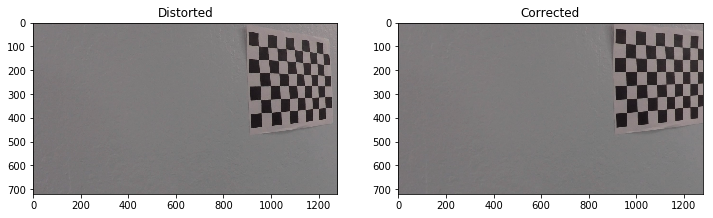

In [5]:
plt.rcParams['figure.figsize'] = 12,12
img = imgs[np.random.randint(0,len(imgs), 1)[0]]
dst = cv2.undistort(img, cdata['results']['mtx'], cdata['results']['dist'], None, cdata['results']['mtx'])
plt.subplot2grid((1,2), (0,0))
plt.imshow(img)
plt.title("Distorted")
plt.subplot2grid((1,2), (0,1))
plt.imshow(dst)
plt.title("Corrected")

## Step 2: Perspective Distortion

Finding the curvature of the lane ahead from the view-point of the camera/driver introduces a series of complexities, due to nonlinearities between left-right lane markings in a 3D world. A great simplification can be introduced by perspectively distorting the image so as to mimick a 'bird's eye view', in which case a the 3D problem is reduced to a quasi 2D problem, where fitting a low degree polynomial to a given set of points is made feasible.

In [6]:
def get_perspective_matrix(src=[], dst=[]):
    """
    Finds the perspective distortion matrix and its inverse

    Parameters
    ----------
    src : ndarray
        Array carying the four source points
    dst : ndarray
        Array for the destination (unwarped) points

    Returns
    -------
    M : ndarray
        The perspective distortion matrix
    M_INV : ndarray
        The inverse perspective distortion matrix
    """
    M = cv2.getPerspectiveTransform(src, dst)
    M_INV = cv2.getPerspectiveTransform(dst, src)
    return M, M_INV

def warp(img, M):
    """
    Warp an image given a perspective distortion matrix

    Parameters
    ----------
    img : ndarray
        Input image to warp
    M : ndarray
        Distortion coefficient matrix

    Returns
    -------
    warped : ndarray
        The warped `img`
    """
    (height, width) = img.shape[:2]
    warped = cv2.warpPerspective(img, M, (width, height), flags=cv2.INTER_LINEAR)
    return warped


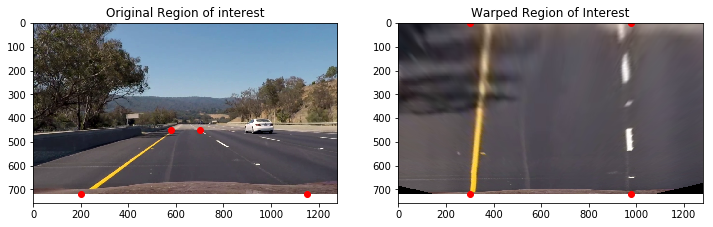

In [7]:
frame = frames_from_video('project_video.mp4', 1)[0]

src = np.float32([
    [200, 720],
    [1150, 720],
    [580, 450],
    [700, 450]])
dst = np.float32([
    [300, 720],
    [980, 720],
    [300, 0],
    [980, 0]])
plt.subplot2grid((1,2), (0,0))
undist = cv2.undistort(frame, cdata['results']['mtx'], cdata['results']['dist'], None, cdata['results']['mtx'])
plt.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
for pt in src:
    plt.plot(pt[0], pt[1], 'ro')
plt.title("Original Region of interest")

plt.subplot2grid((1,2), (0,1))
M, M_INV = get_perspective_matrix(src=src, dst=dst)
warped = warp(undist, M)
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
for pt in dst:
    plt.plot(pt[0], pt[1], 'ro')
plt.title("Warped Region of Interest")

## Step 3: Lane Detection through Color and Edge based binary masking

Lane detection is performed by lane marking binary segmentation. Having an undistorted, perspectively transformed region of interest, a series of binarization steps were performed so as to enable robust lane detection, that performs well under varying lighting conditions, shaddows and different colors.

In order to have robustness with color variance, a horizontal sobel filter was applied with a preset threshold in combination with the saturation channel in HLS colorspace, also with a preset thresholded range. 

In [21]:
def binarize(img, s_thresh=(170, 255), v_thresh=(0,110), edge_thresh=(20, 100)):
    """
    Combined color and edge based masking

    Parameters
    ----------
    img : ndarray
        Input image
    s_thresh : tuple
        The lower and upper thresholds for the S channel
    edge_thresh : tuple
        Lower and upper thresholds for the sobel filter on the L channel

    Returns
    -------
    binary : ndarray
        The binirized combined mask
    """

    img = np.copy(img)
    # Get V Channel from YUV
    V = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2YUV))[2]
    v_binary = np.zeros_like(V)
    v_binary[(V >= v_thresh[0]) & (V <= v_thresh[1])] = 1
    
    # Convert to HLS color space and separate the L channel
    H,L,S = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float))
    # Sobel x
    sobelx = cv2.Sobel(L, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= edge_thresh[0]) & (scaled_sobel <= edge_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(S)
    s_binary[(S >= s_thresh[0]) & (S <= s_thresh[1])] = 1

    sxbinary = sxbinary.astype(np.float) - sxbinary.astype(np.float).min()
    sxbinary /= sxbinary.max()
    
    Z = np.zeros_like(s_binary)
    color_binary = np.dstack((Z, sxbinary, s_binary))
    binary = color_binary.sum(axis=2).astype(np.uint8) * 255
    return binary

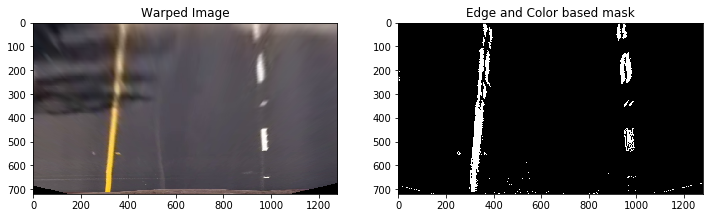

In [9]:
plt.subplot2grid( (2,2), (0,0))
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title('Warped Image')

plt.subplot2grid((2,2), (0,1))
plt.imshow(binarize(warped), cmap='gray')
plt.title('Edge and Color based mask')

# plt.subplot2grid((2,3), (0,2))
# bw = binarize(warped)
# bw = bw.sum(axis=2).astype(np.uint8)
# plt.imshow(bw, cmap='gray')
# plt.title('Combined Mask')

## Step 4: Lane pixel inference

The binary masks extracted thus far still contain plenty of noise. In order to filter it out, a sliding window approach is performed, where pixels around local maximas of the distribution of a subset of the image are picked, assuming the maximas belong to left and right lanes. 

In [10]:
num_framesdef initial_line_fit(binary_warped, nwindows=9, margin=100, minpix=50, polyorder=2):
    """
    Initial sliding window based lane finding

    Parameters
    ----------
    binary_warped : ndarray
        Input binary image
    nwindows : int
        Number of sliding windows
    margin : int
        Width of sliding windows +/- margin
    minpix : int
        Minimum number of pixels found to recenter window
    polyorder : int
        Order of polynomial for line fitting

    Returns
    -------


    """
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype('uint8')
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2.0)
    leftx_base = np.argmax(histogram[margin:midpoint]) + margin
    rightx_base = np.argmax(histogram[midpoint:-margin]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/float(nwindows))
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(
            out_img,
            (win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),
            (0,255,0), 2)
        cv2.rectangle(
            out_img,
            (win_xright_low,win_y_low),
            (win_xright_high,win_y_high),
            (0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = (
            (nonzeroy >= win_y_low) & \
            (nonzeroy < win_y_high) & \
            (nonzerox >= win_xleft_low) & \
            (nonzerox < win_xleft_high)
        ).nonzero()[0]
        good_right_inds = (
            (nonzeroy >= win_y_low) & \
            (nonzeroy < win_y_high) & \
            (nonzerox >= win_xright_low) & \
            (nonzerox < win_xright_high)
        ).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, polyorder)
    right_fit = np.polyfit(righty, rightx, polyorder)

    return {
    'status': True,
    'left_fit': left_fit,
    'right_fit':right_fit,
    'nonzerox': nonzerox,
    'nonzeroy': nonzeroy,
    'out_img': out_img,
    'left_lane_inds': left_lane_inds,
    'right_lane_inds': right_lane_inds
    }

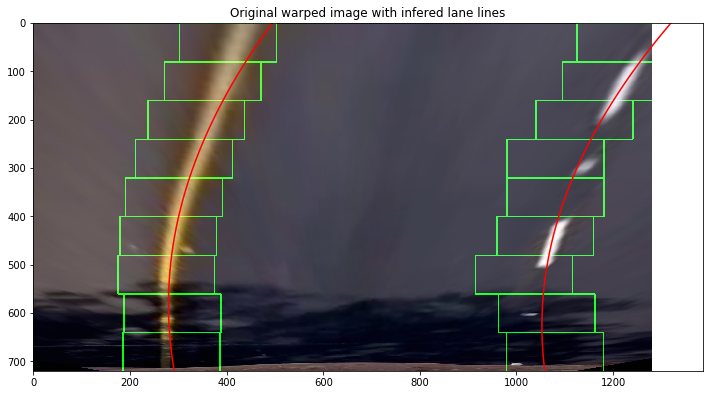

In [43]:
frame = frames_from_video('project_video.mp4', 10, start_indx=1045)[np.random.randint(0,10,1)[0]]

src = np.float32([
    [595, 450],
    [685, 450],
    [1100, 720],
    [200, 720]])
dst = np.float32([
    [300, 0],
    [980, 0],
    [980, 720],
    [300, 720]])

undist = cv2.undistort(frame, cdata['results']['mtx'], cdata['results']['dist'], None, cdata['results']['mtx'])
M, M_INV = get_perspective_matrix(src=src, dst=dst)
warped = warp(undist, M)
bw = binarize(warped)
fits = initial_line_fit(bw)
y = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
x_left, x_right = np.polyval(fits['left_fit'], y), np.polyval(fits['right_fit'], y)
drawn = cv2.addWeighted(warped, 1, fits['out_img'], 1, 1)
plt.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
plt.plot(x_left, y, 'r', x_right, y, 'r')
plt.title("Original warped image with infered lane lines")

## Step 5: Radius of Curvature computation

The end product for the self-driving car application is prediction of the radius of curvature of the lane/road, wich can directly be related to the steering angle of the car. 

Having approximations in functional form of the lanes, the radius of curvature can be solved by

$$
R = \frac{(1 + (\frac{dx}{dy})^2)^\frac{3}{2}}{\frac{d^2x}{dy^2}}
$$

where 
$$
f(y) = Ay^2 + By + C
$$

and hence
$$
f(y)' = 2Ay + B
$$

and
$$
f(y)'' = 2A
$$

Due to the second degree polynomial fit, the equation for radius of curvature becomes

$$
R = \frac{(1 + (2Ay + B)^2)^\frac{3}{2}}{2A}
$$

In [274]:
def compute_curvature(line_fit_dict, xm_per_pix=3.7/700, ym_per_pix=30.0/720):
    """
    Compute radius of curvature

    Parameters
    ----------
    xm_per_pix : float
        Meters per pixel in x dimension
    ym_per_pix : float
        Meters per pixel in y dimension

    Returns
    -------
    """
    y_eval = 719 * ym_per_pix

    # Extract left and right line pixel positions
    leftx = line_fit_dict["nonzerox"][line_fit_dict["left_lane_inds"]]
    lefty = line_fit_dict["nonzeroy"][line_fit_dict["left_lane_inds"]]
    rightx = line_fit_dict["nonzerox"][line_fit_dict["right_lane_inds"]]
    righty = line_fit_dict["nonzeroy"][line_fit_dict["right_lane_inds"]]

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    A2_l, A2_r = 2 * left_fit_cr[0], 2 * right_fit_cr[0]
    B_l, B_r = left_fit_cr[1], right_fit_cr[1]

    left_curverad = ((1 + (A2_l * y_eval + B_l)**2)**1.5) / np.absolute(A2_l)
    right_curverad = ((1 + (A2_r * y_eval + B_r)**2)**1.5) / np.absolute(A2_r)
    # Now our radius of curvature is in meters

    return (left_curverad, right_curverad)

## Step 6: Vehicle offset computation

Computing the vehicle position with respect to the lane it is on, assuming the camera is mounted at the centre of the car, then becomes estimating the difference between the half image width with the average of both lanes.

$$
vehicle\_offset = \frac{1}{2}(image\_width - (left\_line + right\_line))
$$

In [12]:
def get_vehicle_offset(img, left_fit, right_fit, xmppx=3.7/700):
    (height, width) = img.shape[:2]
    left_line = np.polyval(left_fit, height-1)
    right_line = np.polyval(right_fit, height-1)
    vehicle_offset = width / 2.0 - (left_line + right_line)/2
    return vehicle_offset * xmppx

## Step 7: Visualization of Results

In [134]:
def visualize_results(undist, line_fit_dict, M_INV, curvatures, vehicle_offset):
    """
    Final lane line prediction visualized and overlayed on top of original image
    """
    height, width = undist.shape[:2]
    # Generate x and y values for plotting
    ploty = np.linspace(0, height-1, height)
    left_fitx = np.polyval(line_fit_dict['left_fit'], ploty)
    right_fitx = np.polyval(line_fit_dict['right_fit'], ploty)

    color_warp = np.zeros_like(undist)

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarped = cv2.warpPerspective(color_warp, M_INV, (width, height))
    # Combine the result with the original image
    output = cv2.addWeighted(undist, 1, unwarped, 0.3, 0)

    # Annotate lane curvature values and vehicle offset from center
    avg_curve = (curvatures[0] + curvatures[1]) / 2.0
    _str = 'Mean Curvature: %.1f m' % avg_curve
    draw_str(output, (20,30), _str, scale=1.0)
    _str = 'Vehicle offset: %.1f m' % vehicle_offset
    draw_str(output, (20,60), _str, scale=1.0)

    return output

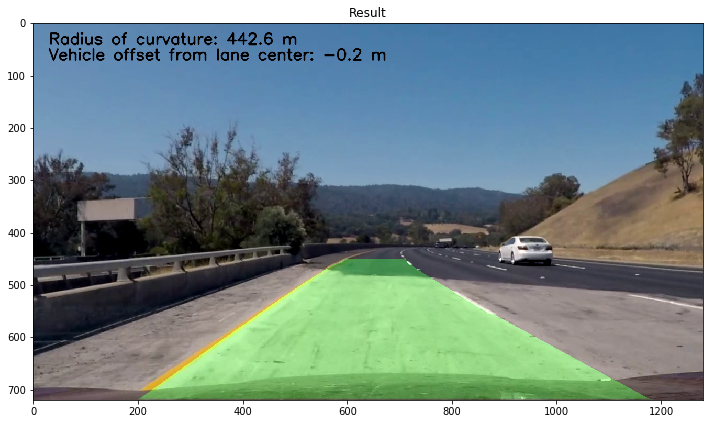

In [287]:
src = np.float32([
    [595, 450],
    [685, 450],
    [1100, 720],
    [200, 720]])
dst = np.float32([
    [300, 0],
    [980, 0],
    [980, 720],
    [300, 720]])
M, M_INV = get_perspective_matrix(src=src, dst=dst)
img = frames_from_video('project_video.mp4', 1)[0]

line_fit_dict, undist = pipe(img, cdata, M, M_INV)
vehicle_offset = get_vehicle_offset(undist,
    line_fit_dict['left_fit'], line_fit_dict['right_fit'])
curvatures = compute_curvature(line_fit_dict)
img = visualize_results(undist, line_fit_dict, M_INV, curvatures,
    vehicle_offset)

plt.imshow(img)
plt.title("Result")

## Result: Video Output

In [17]:
from IPython.display import HTML

# Youtube
HTML('<div style="position:relative;height:0;padding-bottom:56.25%"><iframe src="https://www.youtube.com/embed/GqKTNOwxatY?ecver=2" width="640" height="360" frameborder="0" style="position:absolute;width:100%;height:100%;left:0" allowfullscreen></iframe></div>')

## Result with Outlier Filtering

The pipeline works and covers most of the track well, as can be seen from the above video, however occasianally the algorithm fails to accurately make its prediction. Those rare outliers occur especially at shadowy areas. In order to filter those out, a moving averatge filtering sheme is implemented.

It was chosen that the **queue size** of the moving average filter to be **8**. Additionally, outliers are filtered out by a dynamic threshold, namely if the difference between the mean and the given measurement exceeds six absolute standard deviations, then the image is not added to the queue.

In [288]:
def movav(Q, data, stds=4, axis_thresh=1.5):
    """
    Moving average of a queue with outlier rejection

    Outliers  lying `stds` standard  deviations away from the mean of the queue
    are discarded.

    Parameters
    ----------
    Q : Queue.Queue object
        A Queue object
    data : ndarray
        A queue item candidate
    stds : int
        Number of standard deviations for rejection threshold
    axis_thresh : float
        Threshold for number of correct axes of `data` (within the `stds` standard
        deviations) in order to at an element to the queue `Q`

    Returns
    -------
    movav : ndarray
        The average of the filtered queue
    """
    if Q.full():
        Q.get()

    if len(Q.queue) < (Q.maxsize)-1:
        Q.put(data)
    else:
        current_mean = np.mean(Q.queue, axis=0)
        current_std = np.std(Q.queue, axis=0)
        cond = np.abs(data - current_mean) < (stds * current_std)
        if cond.sum() >= axis_thresh:
            # print("{}: Added new frame".format(time.time()))
            Q.put(data)
        # else:
            # print("{}:Discarded outlier frame".format(time.time()))

    return np.mean(Q.queue, axis=0)

In [289]:
from IPython.display import HTML

# Youtube
HTML('<div style="position:relative;height:0;padding-bottom:56.25%"><iframe src="https://www.youtube.com/embed/GqKTNOwxatY?ecver=2" width="640" height="360" frameborder="0" style="position:absolute;width:100%;height:100%;left:0" allowfullscreen></iframe></div>')

## Discussion

This exercise showed a pipeline that succeeds to find accurately and relatively robust the lane, and estimate the radius of curvature and relative vehicle position, using only a front-facing camera video of a moving car. Although the algorithm shows promising results on the project video, it must be noted that its performance on the challange videos is not satisfactory.

In [ ]:
A